# Setting up Colab environment

In [1]:
import os
username = 'recspert'
repo = 'ITP-SeqRecSys-2024'

# remove local directory if it already exists
if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{username}/{repo}.git

Cloning into 'ITP-SeqRecSys-2024'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 74 (delta 26), reused 58 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (74/74), 473.55 KiB | 1.98 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [2]:
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

  Cloning https://github.com/evfro/polara.git (to revision develop) to /tmp/pip-install-d77j3pke/polara_74afa7a761b046a3b65f512891ea3bbc
  Running command git clone --filter=blob:none --quiet https://github.com/evfro/polara.git /tmp/pip-install-d77j3pke/polara_74afa7a761b046a3b65f512891ea3bbc
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/evfro/polara.git to commit ef7a5360e3f9793f4f0fdd4f31e32399d2e52069
  Preparing metadata (setup.py) ... done
  Created wheel for polara: filename=polara-0.7.2.dev0-py3-none-any.whl size=89422 sha256=9320c8a6a206749626f2e956b8cf4eb8f137c738b555c73767c20dcd3c739637
  Stored in directory: /tmp/pip-ephem-wheel-cache-c2a1yhgc/wheels/3f/3a/1f/42058978e585b23c384652846b96b72870f3c8c12976cdac50
Successfully built polara


In [3]:
from math import ceil

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from numba.typed import List
from numba import njit
from random import seed as set_seed

from time import time

from polara import get_movielens_data
from polara.preprocessing.dataframes import reindex, leave_one_out

# navigating to cloned repo directory in Colab
%cd {repo}
from source.dataprep.dataprep import split_data_global_timepoint
from source.evaluation.evaluation import topn_recommendations, model_evaluate, downvote_seen_items
%cd -

/content/ITP-SeqRecSys-2024
/content


In [4]:
def fix_torch_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Preparing data

In [5]:
data = get_movielens_data(include_time=True)
data_description = {
    'users':'userid',
    'items':'movieid',
    'feedback':'rating',
    'timestamp':'timestamp'
}

In [6]:
training, testset_valid_, holdout_valid_, testset_, holdout_, data_index, data_description = split_data_global_timepoint(data=data, data_description=data_description)

Let's focus on validation part. For convenience, let us also reindex the test users.

In [7]:
userid = data_index['users'].name
test_users = pd.Index(
    # ensure test users are the same across testing data
    np.intersect1d(
        testset_valid_[userid].unique(),
        holdout_valid_[userid].unique()
    )
)
testset_valid = (
    testset_valid_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)
holdout_valid = (
    holdout_valid_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)

In [8]:
holdout_valid.nunique()

,0
userid,736
movieid,551
rating,5
timestamp,736


In [9]:
testset = (
    testset_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)
holdout = (
    holdout_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)

In [10]:
holdout.nunique()

,0
userid,736
movieid,574
rating,5
timestamp,736


In [11]:
assert holdout_valid.set_index('userid')['timestamp'].ge(
    testset_valid
    .groupby('userid')
    ['timestamp'].max()
).all()

In [12]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    order = 'timestamp',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
)
data_description

{'users': 'userid',
 'items': 'movieid',
 'order': 'timestamp',
 'n_users': 5227,
 'n_items': 3652}

# Batch Sampler

In [13]:
from random import randrange
import numpy as np

@njit(fastmath=True)
def sample_unseen(sample_size, sampler_state, remaining, result):
    """
    Sample a desired number of integers from a range (starting from zero)
    excluding black-listed elements defined in sample state. Used with in
    conjunction with `prime_sample_state` method, which initializes state.
    Inspired by Fischer-Yates shuffle.
    """
    # gradually sample from the decreased size range
    for k in range(sample_size):
        i = randrange(remaining) # Randomly select an index in the range of remaining items
        result[k] = sampler_state.get(i, i) # Fetch item or assign i if not found in state
        remaining -= 1 # Decrease the remaining number of items
        sampler_state[i] = sampler_state.get(remaining, remaining)
        sampler_state.pop(remaining, -1) # Remove the last item from the sampler state

@njit(fastmath=True)
def prime_sampler_state(n, exclude):
    """
    Initialize state to be used in `sample_unseen_items`.
    Ensures seen items are never sampled by placing them
    outside of sampling region.
    """
    # initialize typed numba dicts
    state = {n: n}; state.pop(n)
    track = {n: n}; track.pop(n)

    n_pos = n - len(state) - 1
    # reindex excluded items, placing them in the end
    for i, item in enumerate(exclude):
        pos = n_pos - i
        x = track.get(item, item)
        t = state.get(pos, pos)
        state[x] = t
        track[t] = x
        state.pop(pos, n)
        track.pop(item, n)
    return state

In [14]:
@njit
def sample_without_rep(user_items, maxlen, pad_token, n_neg_samples, itemnum, seed):
    # generate n_neg_samples in case of BCE loss
    
    seq = np.full(maxlen, pad_token, dtype=np.int32)
    pos = np.full(maxlen, pad_token, dtype=np.int32)
    neg = np.full((maxlen, n_neg_samples), pad_token, dtype=np.int32)

    hist_items_counter = 1
    nxt = user_items[-1]
    idx = maxlen - 1

    set_seed(seed)

    ts_ = list(set(user_items))

    for i in user_items[-2::-1]:
        seq[idx] = i
        pos[idx] = nxt

        state = prime_sampler_state(itemnum, ts_)
        remaining = itemnum - len(ts_)

        sample_unseen(n_neg_samples, state, remaining, neg[idx])

        nxt = i
        idx -= 1
        hist_items_counter += 1
        if idx == -1:
            break

    neg = np.swapaxes(neg, 0, 1)
    return seq, pos, neg

def no_sample(user_items, maxlen, pad_token):
    # return positive, leave negative empty
    # used for CE and SCE
    
    seq = ...
    pos = ...
    neg = ...

    return seq, pos, neg

class SequentialDataset(Dataset):
    def __init__(self, user_train, usernum, itemnum, maxlen, seed, n_neg_samples=1, sampling='without_rep', pad_token=None):
        super().__init__()
        self.user_train = user_train

        self.valid_users = [user for user in range(usernum) if len(user_train.get(user, [])) > 1]

        self.usernum = len(self.valid_users)

        self.itemnum = itemnum
        self.maxlen = maxlen
        self.seed = seed
        self.n_neg_samples = n_neg_samples
        self.sampling = sampling

        self.pad_token = pad_token

        self.random_state = np.random.RandomState(self.seed)

    def __len__(self):
        return self.usernum

    def __getitem__(self, idx):
        user = self.valid_users[idx]
        user_items = List()
        [user_items.append(x) for x in self.user_train[user]]
        
        if self.sampling == 'without_rep':
            seq, pos, neg = sample_without_rep(user_items, self.maxlen, self.pad_token, self.n_neg_samples, self.itemnum, self.random_state.randint(np.iinfo(int).min, np.iinfo(int).max))

        elif self.sampling == 'no_sampling':
            seq, pos, neg = no_sample(user_items, self.maxlen, self.pad_token)

        return user, seq, pos, neg

# SASRec model

The code is adapted from https://github.com/pmixer/SASRec.pytorch

In [15]:
class PointWiseFeedForward(nn.Module):
    def __init__(self, hidden_units, dropout_rate):

        super(PointWiseFeedForward, self).__init__()

        self.conv1 = nn.Conv1d(hidden_units, hidden_units, kernel_size=1)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(hidden_units, hidden_units, kernel_size=1)
        self.dropout2 = nn.Dropout(p=dropout_rate)

    def forward(self, inputs):
        outputs = self.dropout2(self.conv2(self.relu(self.dropout1(self.conv1(inputs.transpose(-1, -2))))))
        outputs = outputs.transpose(-1, -2) # as Conv1D requires (N, C, Length)
        outputs += inputs
        return outputs


class SASRecBackBone(nn.Module):
    def __init__(self, item_num, config):
        super(SASRecBackBone, self).__init__()
        self.item_num = item_num
        self.pad_token = item_num

        self.item_emb = nn.Embedding(self.item_num+1, config['hidden_units'], padding_idx=self.pad_token)
        self.pos_emb = nn.Embedding(config['maxlen'], config['hidden_units'])
        self.emb_dropout = nn.Dropout(p=config['dropout_rate'])

        self.attention_layernorms = nn.ModuleList() # to be Q for self-attention
        self.attention_layers = nn.ModuleList()
        self.forward_layernorms = nn.ModuleList()
        self.forward_layers = nn.ModuleList()
        self.last_layernorm = nn.LayerNorm(config['hidden_units'], eps=1e-8)

        for _ in range(config['num_blocks']):
            new_attn_layernorm = nn.LayerNorm(config['hidden_units'], eps=1e-8)
            self.attention_layernorms.append(new_attn_layernorm)
            new_attn_layer =  nn.MultiheadAttention(
                config['hidden_units'],config['num_heads'],config['dropout_rate']
            )
            self.attention_layers.append(new_attn_layer)

            new_fwd_layernorm = nn.LayerNorm(config['hidden_units'], eps=1e-8)
            self.forward_layernorms.append(new_fwd_layernorm)

            new_fwd_layer = PointWiseFeedForward(config['hidden_units'], config['dropout_rate'])
            self.forward_layers.append(new_fwd_layer)

        fix_torch_seed(config['manual_seed'])
        self.initialize()

    def initialize(self):
        for _, param in self.named_parameters():
            try:
                torch.nn.init.xavier_uniform_(param.data)
            except:
                pass # just ignore those failed init layers

    def log2feats(self, log_seqs):
        device = log_seqs.device
        
        seqs = ...

        timeline_mask = log_seqs == self.pad_token
        seqs *= ~timeline_mask.unsqueeze(-1) # broadcast in last dim

        tl = seqs.shape[1] # time dim len for enforce causality
        attention_mask = ~torch.tril(torch.full((tl, tl), True, device=device))

        for i in range(len(self.attention_layers)):
            seqs = torch.transpose(seqs, 0, 1)
            Q = self.attention_layernorms[i](seqs)
            mha_outputs, _ = self.attention_layers[i](
                Q, seqs, seqs, attn_mask=attention_mask
            )

            seqs = Q + mha_outputs
            seqs = torch.transpose(seqs, 0, 1)

            seqs = self.forward_layernorms[i](seqs)
            seqs = self.forward_layers[i](seqs)
            seqs *=  ~timeline_mask.unsqueeze(-1)

        log_feats = self.last_layernorm(seqs) # (U, T, C) -> (U, -1, C)

        return log_feats

    def forward(self, log_seqs, pos_seqs, neg_seqs):
        log_feats = ...
        pos_embs = ...
        neg_embs = ...

        pos_logits = ...
        neg_logits = ...

        return pos_logits, neg_logits

    def score(self, seq):
        '''
        Takes 1d sequence as input and returns prediction scores.
        '''
        maxlen = self.pos_emb.num_embeddings
        
        log_seqs = torch.full([maxlen], self.pad_token, dtype=torch.int64, device=seq.device)
        log_seqs = ...
        logits = ...
        
        return logits


class SASRec(SASRecBackBone):
    def __init__(self, item_num, config):
        super().__init__(item_num + 1, config)

        self.fwd_type = config['fwd_type']

        if self.fwd_type == 'bce':
            self.n_neg_samples = config['n_neg_samples']

        if self.fwd_type == 'sce':
            self.n_buckets = config['n_buckets']
            self.bucket_size_x = eval(config['bucket_size_x']) if type(config['bucket_size_x']) == str else config['bucket_size_x']
            self.bucket_size_y = eval(config['bucket_size_y']) if type(config['bucket_size_y']) == str else config['bucket_size_y']

            self.mix_x = config['mix_x']


    def forward(self, log_seqs, pos_seqs, neg_seqs):
        if self.fwd_type == 'bce':
            return self.bce_forward(log_seqs, pos_seqs, neg_seqs)

        elif self.fwd_type == 'ce':
            return self.ce_forward(log_seqs, pos_seqs)

        if self.fwd_type == 'sce':
            return self.sce_forward(log_seqs, pos_seqs)

        else:
            raise ValueError(f'Wrong fwd_type type - {self.fwd_type}')

    def bce_forward(self, log_seqs, pos_seqs, neg_seqs):
        device = log_seqs.device
        pos_logits, neg_logits = super().forward(log_seqs, pos_seqs, neg_seqs)

        pos_logits = pos_logits[:, :, None]
        neg_logits = neg_logits.permute(0, 2, 1)

        pos_labels = torch.ones(pos_logits.shape, device=device)
        neg_labels = torch.zeros(neg_logits.shape, device=device)

        logits = torch.cat([pos_logits, neg_logits], -1)

        gt = torch.cat([pos_labels, neg_labels], -1)

        mask = (pos_seqs != self.pad_token).float()

        loss_per_element = torch.nn.functional.binary_cross_entropy_with_logits(logits, gt, reduction='none').mean(-1) * mask
        loss = loss_per_element.sum() / mask.sum()

        return loss

    def ce_forward(self, log_seqs, pos_seqs):
        emb = ...
        logits = ...
        indices = torch.where(pos_seqs.view(-1) != self.pad_token)
        loss = F.cross_entropy(logits.view(-1, logits.shape[-1])[indices], pos_seqs.view(-1)[indices], reduction='mean')
        return loss

    def sce_forward(self, log_seqs, pos_seqs):
        emb = self.log2feats(log_seqs)
        hd = emb.shape[-1]

        x = emb.view(-1, hd)
        y = pos_seqs.view(-1)
        w = self.item_emb.weight

        correct_class_logits_ = (x * torch.index_select(w, dim=0, index=y)).sum(dim=1) # (bs,)

        with torch.no_grad():
            if self.mix_x:
                omega = 1/np.sqrt(np.sqrt(hd)) * torch.randn(x.shape[0], self.n_buckets, device=x.device)
                buckets = omega.T @ x
                del omega
            else:
                buckets = 1/np.sqrt(np.sqrt(hd)) * torch.randn(self.n_buckets, hd, device=x.device) # (n_b, hd)

        with torch.no_grad():
            x_bucket = buckets @ x.T # (n_b, hd) x (hd, b) -> (n_b, b)
            x_bucket[:, log_seqs.view(-1) == self.pad_token] = float('-inf')
            _, top_x_bucket = torch.topk(x_bucket, dim=1, k=self.bucket_size_x) # (n_b, bs_x)
            del x_bucket

            y_bucket = buckets @ w.T # (n_b, hd) x (hd, n_cl) -> (n_b, n_cl)

            y_bucket[:, self.pad_token] = float('-inf')
            _, top_y_bucket = torch.topk(y_bucket, dim=1, k=self.bucket_size_y) # (n_b, bs_y)
            del y_bucket

        x_bucket = torch.gather(x, 0, top_x_bucket.view(-1, 1).expand(-1, hd)).view(self.n_buckets, self.bucket_size_x, hd) # (n_b, bs_x, hd)
        y_bucket = torch.gather(w, 0, top_y_bucket.view(-1, 1).expand(-1, hd)).view(self.n_buckets, self.bucket_size_y, hd) # (n_b, bs_y, hd)

        wrong_class_logits = (x_bucket @ y_bucket.transpose(-1, -2)) # (n_b, bs_x, bs_y)
        mask = torch.index_select(y, dim=0, index=top_x_bucket.view(-1)).view(self.n_buckets, self.bucket_size_x)[:, :, None] == top_y_bucket[:, None, :] # (n_b, bs_x, bs_y)
        wrong_class_logits = wrong_class_logits.masked_fill(mask, float('-inf')) # (n_b, bs_x, bs_y)
        correct_class_logits = torch.index_select(correct_class_logits_, dim=0, index=top_x_bucket.view(-1)).view(self.n_buckets, self.bucket_size_x)[:, :, None] # (n_b, bs_x, 1)
        logits = torch.cat((wrong_class_logits, correct_class_logits), dim=2) # (n_b, bs_x, bs_y + 1)

        loss_ = F.cross_entropy(logits.view(-1, logits.shape[-1]), (logits.shape[-1] - 1) * torch.ones(logits.shape[0] * logits.shape[1], dtype=torch.int64, device=logits.device), reduction='none') # (n_b * bs_x,)
        loss = torch.zeros(x.shape[0], device=x.device, dtype=x.dtype)
        loss.scatter_reduce_(0, top_x_bucket.view(-1), loss_, reduce='amax', include_self=False)
        loss = loss[(loss != 0) & (y != self.pad_token)]
        loss = torch.mean(loss)

        return loss

# Training

In [16]:
def data_to_sequences(data, data_description):
    userid = data_description['users']
    itemid = data_description['items']
    sequences = (
        data.sort_values([userid, data_description['order']])
        .groupby(userid, sort=False)[itemid].apply(list)
    )
    return sequences

In [17]:
def prepare_sasrec_model(config, data, data_description):
    n_users = data_description['n_users']
    n_items = data_description['n_items']
    model = SASRec(n_items, config)
    if torch.cuda.is_available():
        model = model.cuda()

    train_sequences = data_to_sequences(data, data_description)
    sampler = DataLoader(SequentialDataset(train_sequences, n_users, n_items,
        maxlen = config['maxlen'],
        seed = config['sampler_seed'],
        n_neg_samples = config['n_neg_samples'],
        pad_token = model.pad_token,
        sampling = config['sampling']), batch_size=config['batch_size'], shuffle=True, num_workers=2, pin_memory=True, prefetch_factor=10, drop_last=True)

    n_batches = len(train_sequences) // config['batch_size']
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr = config['learning_rate'],
        betas = (0.9, 0.98)
    )
    return model, sampler, n_batches, optimizer

In [18]:
def train_sasrec_epoch(model, num_batch, l2_emb, sampler, optimizer, device):
    model.train()
    pad_token = model.pad_token
    losses = []
    for _, *seq_data in sampler:
        # convert batch data into torch tensors
        seq, pos, neg = (torch.LongTensor(np.array(x)).to(device) for x in seq_data)
        loss = ...
    return losses

In [19]:
def sasrec_model_scoring(params, data, data_description):
    model = params
    model.eval()
    tensor = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
    test_sequences = data_to_sequences(data, data_description)
    # perform scoring on a user-batch level
    scores = []
    for _, seq in test_sequences.items():
        ...
    return np.concatenate(scores, axis=0)

In [20]:
def build_sasrec_model(config, data, data_description):
    '''Simple MF training routine without early stopping'''
    model, sampler, n_batches, optimizer = prepare_sasrec_model(config, data, data_description)
    device = 'cpu'
    if torch.cuda.is_available():
        device = torch.device(f'cuda:{torch.cuda.current_device()}')
    losses = {}
    hr, mrr, cov = {}, {}, {}
    best_hr = 0
    wait = 0
    start_time = time()
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

    for epoch in tqdm(range(config['num_epochs'])):
        losses[epoch] = train_sasrec_epoch(
            model, n_batches, config['l2_emb'], sampler, optimizer, device
        )
        val_scores = sasrec_model_scoring(model, testset_valid, data_description)
        downvote_seen_items(val_scores, testset_valid, data_description)
        val_recs = topn_recommendations(val_scores, topn=10)
        metrics = model_evaluate(val_recs, holdout_valid, data_description)
        hr_ = metrics['hr']
        mrr_ = metrics['mrr']
        cov_ = metrics['cov']

        hr[epoch] = hr_
        mrr[epoch] = mrr_
        cov[epoch] = cov_

        if hr_ > best_hr:
          best_hr = hr_
          wait = 0
        elif wait < 20:
          wait += 1
        else:
          break

    torch.cuda.synchronize()
    training_time_sec = time() - start_time
    full_peak_training_memory_bytes = torch.cuda.max_memory_allocated()
    training_epoches = len(losses)

    print('Peak training memory, mb:', round(full_peak_training_memory_bytes/ 1024. / 1024., 2))
    print('Training epoches:', training_epoches)
    print('Training time, m:', round(training_time_sec/ 60., 2))

    return model, losses, hr, mrr, cov

In [21]:
base_config_test = dict(
    num_epochs = 1,
    maxlen = 200,
    hidden_units = 64,
    dropout_rate = 0.4,
    num_blocks = 2,
    num_heads = 1,
    batch_size = 2048,
    sampler_seed = 99,
    manual_seed = 111,
    learning_rate = 1e-3,
    l2_emb = 0,
    n_neg_samples = 0,
    sampling = 'no_sampling',
)

In [ ]:
config_sce_test = base_config_test.copy()
config_sce_test['mix_x'] = True
config_sce_test['n_buckets'] = 500
config_sce_test['bucket_size_x'] = 500
config_sce_test['bucket_size_y'] = 200
config_sce_test['fwd_type'] = 'sce'

model_sce_test, losses_sce, hr_sce, mrr_sce, cov_sce = build_sasrec_model(config_sce_test, training, data_description)

In [ ]:
config_ce_test = base_config_test.copy()
config_ce_test['fwd_type'] = 'ce'

model_ce_test, losses_ce, hr_ce, mrr_ce, cov_ce = build_sasrec_model(config_ce_test, training, data_description)

In [ ]:
config_bce_test = base_config_test.copy()
config_bce_test['fwd_type'] = 'bce'
config_bce_test['n_neg_samples'] = 32
config_bce_test['sampling'] = 'without_rep'

model_bce_test, losses_bce, hr_bce, mrr_bce, cov_bce = build_sasrec_model(config_bce_test, training, data_description)

# Let's train the models

In [25]:
base_config = dict(
    num_epochs = 20,
    maxlen = 200,
    hidden_units = 64,
    dropout_rate = 0.4,
    num_blocks = 2,
    num_heads = 1,
    batch_size = 256,
    sampler_seed = 99,
    manual_seed = 111,
    learning_rate = 1e-3,
    l2_emb = 0,
    sampling = 'no_sampling',
    n_neg_samples = 0
)

In [26]:
config_bce = base_config.copy()
config_bce['fwd_type'] = 'bce'
config_bce['n_neg_samples'] = 32
config_bce['sampling'] = 'without_rep'

In [27]:
model_bce, losses_bce, hr_bce, mrr_bce, cov_bce = build_sasrec_model(config_bce, training, data_description)

  0%|          | 0/20 [00:00<?, ?it/s]

Peak training memory, mb: 1747.67
Training epoches: 20
Training time, m: 12.69


In [28]:
config_ce = base_config.copy()
config_ce['fwd_type'] = 'ce'

In [29]:
model_ce, losses_ce, hr_ce, mrr_ce, cov_ce = build_sasrec_model(config_ce, training, data_description)

  0%|          | 0/20 [00:00<?, ?it/s]

Peak training memory, mb: 2014.73
Training epoches: 20
Training time, m: 3.07


In [30]:
config_sce = base_config.copy()
config_sce['mix_x'] = False
config_sce['n_buckets'] = 500
config_sce['bucket_size_x'] = 500
config_sce['bucket_size_y'] = 200
config_sce['fwd_type'] = 'sce'


In [31]:
model_sce, losses_sce, hr_sce, mrr_sce, cov_sce = build_sasrec_model(config_sce, training, data_description)

  0%|          | 0/20 [00:00<?, ?it/s]

Peak training memory, mb: 1238.74
Training epoches: 20
Training time, m: 3.05


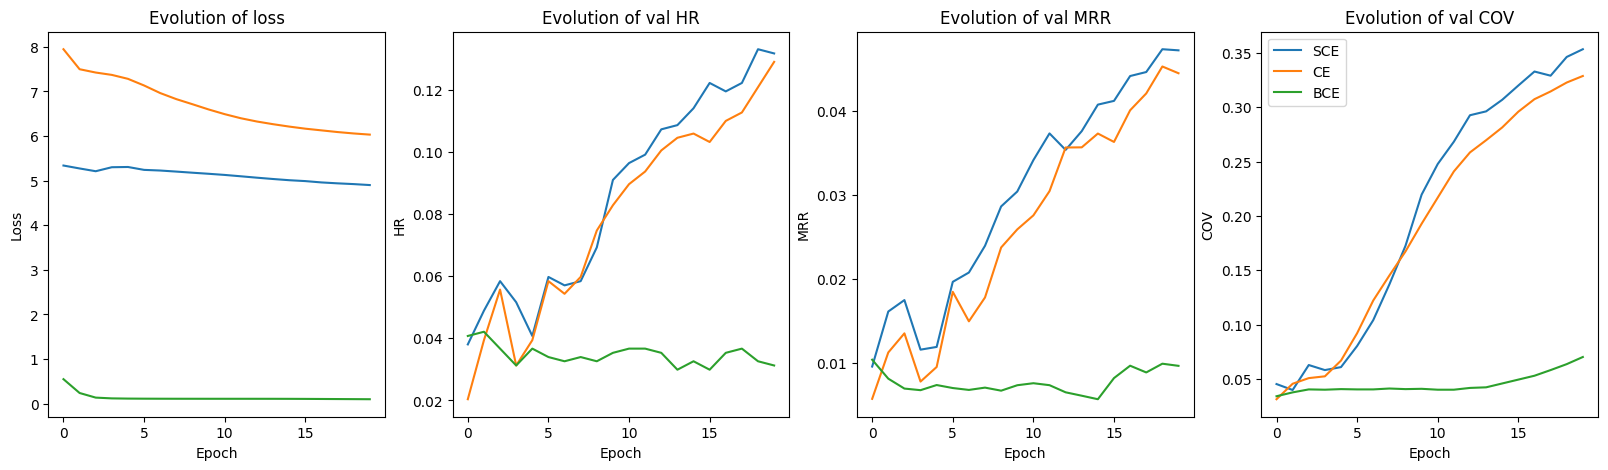

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
pd.Series(losses_sce).apply(np.mean).plot(title='Evolution of loss', xlabel='Epoch', ylabel='Loss', ax=ax[0], label='SCE');
pd.Series(hr_sce).apply(np.mean).plot(title='Evolution of val HR', xlabel='Epoch', ylabel='HR', ax=ax[1], label='SCE');
pd.Series(mrr_sce).apply(np.mean).plot(title='Evolution of val MRR', xlabel='Epoch', ylabel='MRR', ax=ax[2], label='SCE');
pd.Series(cov_sce).apply(np.mean).plot(title='Evolution of val COV', xlabel='Epoch', ylabel='COV', ax=ax[3], label='SCE');

pd.Series(losses_ce).apply(np.mean).plot(title='Evolution of loss', xlabel='Epoch', ylabel='Loss', ax=ax[0], label='CE');
pd.Series(hr_ce).apply(np.mean).plot(title='Evolution of val HR', xlabel='Epoch', ylabel='HR', ax=ax[1], label='CE');
pd.Series(mrr_ce).apply(np.mean).plot(title='Evolution of val MRR', xlabel='Epoch', ylabel='MRR', ax=ax[2], label='CE');
pd.Series(cov_ce).apply(np.mean).plot(title='Evolution of val COV', xlabel='Epoch', ylabel='COV', ax=ax[3], label='CE');

pd.Series(losses_bce).apply(np.mean).plot(title='Evolution of loss', xlabel='Epoch', ylabel='Loss', ax=ax[0], label='BCE');
pd.Series(hr_bce).apply(np.mean).plot(title='Evolution of val HR', xlabel='Epoch', ylabel='HR', ax=ax[1], label='BCE');
pd.Series(mrr_bce).apply(np.mean).plot(title='Evolution of val MRR', xlabel='Epoch', ylabel='MRR', ax=ax[2], label='BCE');
pd.Series(cov_bce).apply(np.mean).plot(title='Evolution of val COV', xlabel='Epoch', ylabel='COV', ax=ax[3], label='BCE');

plt.legend()

# Evaluation

In [33]:
# SASRec BCE
sasrec_scores_bce = sasrec_model_scoring(model_bce, testset, data_description)
downvote_seen_items(sasrec_scores_bce, testset, data_description)

sasrec_recs_bce = topn_recommendations(sasrec_scores_bce, topn=10)
model_evaluate(sasrec_recs_bce, holdout, data_description)

{'hr': 0.036684782608695655,
 'mrr': 0.006975716011042098,
 'cov': 0.07119386637458927}

In [34]:
# CE
sasrec_scores_ce = sasrec_model_scoring(model_ce, testset, data_description)
downvote_seen_items(sasrec_scores_ce, testset, data_description)

sasrec_recs_ce = topn_recommendations(sasrec_scores_ce, topn=10)
model_evaluate(sasrec_recs_ce, holdout, data_description)

{'hr': 0.12228260869565218,
 'mrr': 0.047403920807453426,
 'cov': 0.3359802847754655}

In [35]:
# SCE
sasrec_scores_sce = sasrec_model_scoring(model_sce, testset, data_description)
downvote_seen_items(sasrec_scores_sce, testset, data_description)

sasrec_recs_sce = topn_recommendations(sasrec_scores_sce, topn=10)
model_evaluate(sasrec_recs_sce, holdout, data_description)

{'hr': 0.11141304347826086,
 'mrr': 0.04683348429951691,
 'cov': 0.35076670317634173}